In [1106]:
import gpxpy
import gpxpy.gpx

city = 'flanders'
filename = 'data/'+city+'.gpx'

gpx = gpxpy.parse(open(filename,'r'))
new_points = []
points = gpx.tracks[0].segments[0].points
for i, point in enumerate(points):
    if i==0:
        new_points.append(point)
    else:
        if point.latitude != points[i-1].latitude and point.longitude != points[i-1].longitude:
            new_points.append(point)
gpx.tracks[0].segments[0].points = new_points
open(filename,'w').write(gpx.to_xml())
gpx = gpxpy.parse(open(filename,'r'))
alts = [point.elevation for point in gpx.tracks[0].segments[0].points]

<AxesSubplot:>

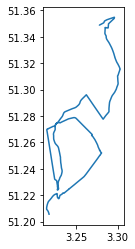

In [1107]:
import geopandas as gpd
track = gpd.GeoDataFrame(columns=['name', 'geometry'], 
     geometry='geometry')
gdf = gpd.read_file(filename, layer='tracks')
gdf.plot()

In [1104]:
import srtm1
def coord_to_alt(coord):
    lat = coord[1]
    lon = coord[0]
    return srtm1.read('data/ASTGTMV003_N40W074_dem.tif',lat, lon)

coord1 = gdf.geometry[0].coords[0]
print(coord1)
lat = coord1[1]
lon = coord1[0]
alts = [coord_to_alt(coord) for coord in gdf.geometry[0].coords]
alt_diffs = [alts[i+1]-alts[i] for i in range(len(alts)-1)]

plt.plot(alts)
plt.plot(alt_diffs)

NotImplementedError: Multi-part geometries do not provide a coordinate sequence

In [1105]:
import sys
sys.path.append('../SRTM-GeoTIFF/library')
import tilename
tilename.find(gdf.geometry[0].coords[0][1],gdf.geometry[0].coords[0][0])

NotImplementedError: Multi-part geometries do not provide a coordinate sequence

In [1110]:
gdf.head()

,name,cmt,desc,src,link1_href,link1_text,link1_type,link2_href,link2_text,link2_type,number,type,geometry
0,Flanders 2021 ME ITT,None,None,Generated by Anonymous using La Flamme Rouge t...,None,None,None,None,None,None,None,None,"LINESTRING (3.27762 51.34923, 3.27784 51.34893..."


In [1057]:
len(gdf.geometry[0].geoms[0].coords)

3190

In [1108]:
#from shapely import geometry, ops
#singleline = ops.linemerge(gdf.geometry[0])
gdf.geometry[0]=gdf.geometry[0].geoms[0]

In [1109]:
gdf.head()
print(gdf.geometry[0].coords[0])
gdf.crs

(3.27762, 51.34923)


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# Radius Calculation

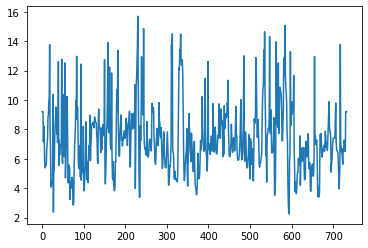

In [1111]:
import pymap3d as pm
import numpy as np
import matplotlib.pyplot as plt
lat0 = gdf.geometry[0].coords[0][1]
lon0 = gdf.geometry[0].coords[0][0]
h0 = 0
lat = gdf.geometry[0].coords[1][1]
lon = gdf.geometry[0].coords[1][0]
h = 0
def get_local_coord(coord, coord0):
    lat0 = coord0[1]
    lon0 = coord0[0]
    lat = coord[1]
    lon = coord[0]
    return pm.geodetic2enu(lat, lon, 0, lat0, lon0, h0)[:2]
coords = gdf.geometry[0].coords
local_coords = [ get_local_coord(coord, coords[0]) for coord in coords]
local_coords

from scipy import optimize

x = [i[0] for i in local_coords[0:5]]
y = [i[1] for i in local_coords[0:5]]
x=[]
y=[]

def calc_R(xc, yc, x, y):
    """ calculate the distance of each 2D points from the center (xc, yc) """
    return np.sqrt((x-xc)**2 + (y-yc)**2)

def f_2(c, x, y):
    """ calculate the algebraic distance between the data points and the mean circle centered at c=(xc, yc) """
    Ri = np.sqrt((x-c[0])**2 + (y-c[1])**2)
    return Ri - Ri.mean()

def get_radius(i, local_coords, k):
    if i<k:
        return 10000
    if i+k>=len(local_coords):
        return 10000
    point_set = local_coords[i-k:i+k]
    x = [i[0] for i in point_set]
    y = [i[1] for i in point_set]
    
    center_estimate = (np.mean(x),np.mean(y))
    center, ier = optimize.leastsq(f_2, center_estimate, args=(x, y))
    #print(ier)
    Ri_2       = calc_R(*center, x, y)
    R_2        = Ri_2.mean()
    return R_2

get_radius(190, local_coords, 100)
radii = [get_radius(i, local_coords, 3) for i in range(len(local_coords))]
heights = alts
plt.plot(np.log(radii))

732
732


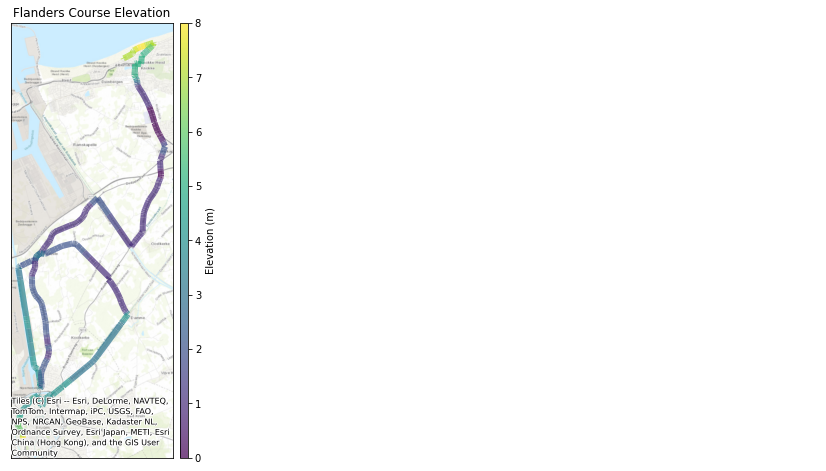

In [1113]:
from shapely.geometry import Point
from shapely.geometry import LineString
from matplotlib import cm
from matplotlib.colors import LogNorm
import contextily as cx
from mpl_toolkits.axes_grid1 import make_axes_locatable

def segments(curve):
    return list(map(LineString, zip(curve.coords[:-1], curve.coords[1:])))

line_segments = segments(gdf.geometry[0])
segment_radius = [(radii[i]+radii[i+1])/2 for i in range(len(radii)-1)]
segment_height = [(heights[i]+heights[i+1])/2 for i in range(len(heights)-1)]
print(len(segment_radius))
print(len(segment_height))

tokyo_lines = gpd.GeoDataFrame(columns=['radius','geometry'],geometry='geometry')
tokyo_lines.geometry = line_segments
tokyo_lines.radius = segment_height#segment_radius#

tokyo_lines.crs='epsg:4326'
tokyo_lines = tokyo_lines.to_crs(epsg=3857)

fig, ax = plt.subplots(1, 1, figsize=(8,8))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1, title="")
tokyo_lines.plot(tokyo_lines.radius,linewidth=6,figsize=(10,10),ax=ax,cax = cax, cmap=cm.viridis,
                legend_kwds={'label': "Elevation (m)", "alpha":0.7}, alpha=0.7, legend=True)#norm=LogNorm(vmin=tokyo_lines.radius.min(), vmax=tokyo_lines.radius.max())
cx.add_basemap(ax, source=cx.providers.Esri.WorldTopoMap)
ax.title.set_text('Flanders Course Elevation')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.savefig('flanders-height.png', dpi=300, bbox_inches='tight')
#tokyo.explore(tokyo.radius)

# Point(coords[0])
# tokyo = gpd.GeoDataFrame(columns=['radius', 'geometry'], 
#          geometry='geometry')
# points = [Point(coords[i]) for i in range(len(coords))]
# tokyo.geometry = points
# tokyo.radius = np.log(radii)
# tokyo.explore(tokyo.radius)

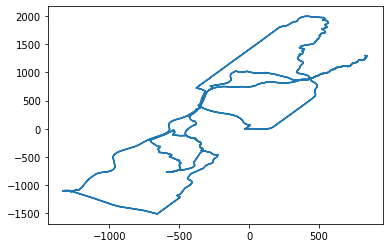

In [1063]:
x = [i[0] for i in local_coords]
y = [i[1] for i in local_coords]
plt.plot(x,y)

# Distance, altitude and slope calculation

(-73.9626355, 40.7816163)


2887

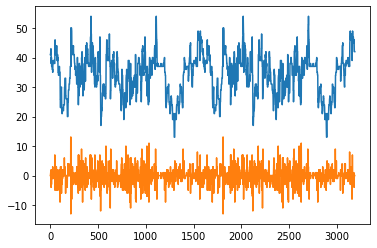

In [1070]:
coord1 = gdf.geometry[0].coords[0]
print(coord1)
lat = coord1[1]
lon = coord1[0]
alt_diffs = [alts[i+1]-alts[i] for i in range(len(alts)-1)]
plt.plot(alts)
plt.plot(alt_diffs)
sum([abs(diff) for diff in alt_diffs])


10.326379429495647


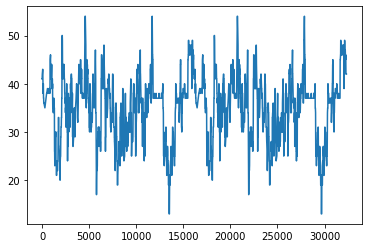

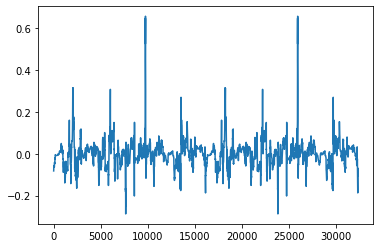

In [1075]:
from haversine import haversine_vector, Unit
import numpy as np
coords_latlon = [x[::-1] for x in gdf.geometry[0].coords]
dists = haversine_vector(coords_latlon[1:],coords_latlon[:-1], Unit.METERS)
#slopes = alt_diffs/dists #too noisy!
sum(dists)
print(np.sqrt(np.var(dists)))
cum_dists = np.insert(np.cumsum(dists),0,0)
smoothing = 18
alt_diffs_smooth = [alts[(i+smoothing)%len(alts)]-alts[i-smoothing] for i in range(len(alts))]
dists_smooth = haversine_vector(np.roll(coords_latlon,-smoothing),np.roll(coords_latlon,smoothing), Unit.METERS)
slopes = alt_diffs_smooth/dists_smooth
#cum_dists_smooth = np.cumsum(dists_smooth)
#todo: calculate slopes CENTERED around points

plt.plot(cum_dists,alts)
plt.show()
plt.plot(cum_dists,slopes)

(array([2.743e+03, 3.620e+02, 5.200e+01, 1.400e+01, 1.200e+01, 4.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([4.73997803e-02, 1.70748401e+01, 3.41022805e+01, 5.11297209e+01,
        6.81571613e+01, 8.51846016e+01, 1.02212042e+02, 1.19239482e+02,
        1.36266923e+02, 1.53294363e+02, 1.70321803e+02]),
 <BarContainer object of 10 artists>)

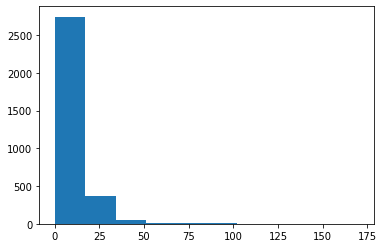

In [1076]:
plt.hist(dists)

# Heading calculation

(array([548., 334., 128., 346., 216., 506., 466., 200., 182., 264.]),
 array([-3.12438753, -2.50094309, -1.87749865, -1.25405422, -0.63060978,
        -0.00716534,  0.6162791 ,  1.23972354,  1.86316798,  2.48661241,
         3.11005685]),
 <BarContainer object of 10 artists>)

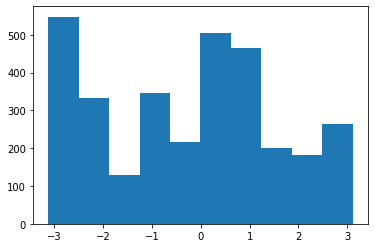

In [1077]:
import math
dirs = []
for i in range(len(coords_latlon)):
    coord1 = coords_latlon[i]
    coord2 = coords_latlon[(i+1)%len(coords_latlon)]
    
    lat1 = math.radians(coord1[0])
    lat2 = math.radians(coord2[0])

    diffLong = math.radians(coord2[1] - coord1[1])

    x = math.sin(diffLong) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - (math.sin(lat1)
            * math.cos(lat2) * math.cos(diffLong))

    initial_bearing = math.atan2(x, y)
    dirs.append(initial_bearing)
plt.hist(dirs)

# Track data structures

In [1080]:
import math
from math import sin, cos
g = 9.81
mu_s = 1#0.3
mu = 0.0025#*1.3
points = []

for i in range(len(alts)):
    theta = math.radians(5)
    r = radii[i]
    vmax = math.sqrt(r * g * (sin(theta)+mu_s * cos(theta))/(cos(theta)-mu_s * sin(theta)))
    point = {'lon': gdf.geometry[0].coords[0], 'lat': gdf.geometry[0].coords[1],
             'alt': alts[i], 'slope': slopes[i], 'radius': radii[i], 'cumdist':cum_dists[i],
             'vmax':vmax, 'hdg':dirs[i]}
    points.append(point)

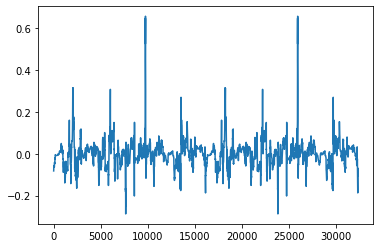

In [1081]:
plt.plot([p['cumdist'] for p in points], [p['slope'] for p in points])

In [1082]:
def interp(d1, d2, weight):
    return d1 * weight + d2 * (1-weight)
import math

from tqdm import tqdm
def data(x):
    #i=np.argmax([p['cumdist']>0 for p in points])
#     i=0
#     while(points[i]['cumdist']<x) and i<100000:
#         i+=1
    i = np.searchsorted(cum_dists, x)
    if i==100000: print('hmm')
    p1 = points[i-1]
    p2 = points[i]
    weight = (p2['cumdist']-x)/(p2['cumdist']-p1['cumdist'])
    slope = np.arctan(interp(p1['slope'],p2['slope'],weight))
    r = interp(p1['radius'],p2['radius'],weight)
    vmax = interp(p1['vmax'],p2['vmax'],weight)
    alt = interp(p1['alt'],p2['alt'],weight)
    hdg = interp(p1['hdg'],p2['hdg'],weight)

    
    return slope, r, vmax, alt, hdg

    

In [1083]:
g = 9.81
data_compr = 10
slope_data = []
vmax_data = []
fric_slope_data = []
hdg_data = []
for x in tqdm(range(math.ceil(max(cum_dists)/data_compr))):
    slope = data(x*data_compr)[0]
    vmax = data(x*data_compr)[2]
    slope_data.append(slope)
    vmax_data.append(vmax)
    fric_slope_data.append(g*(math.sin(slope)+mu*math.cos(slope)))
    hdg_data.append(data(x*data_compr)[4])
    #x_data.append([data(x)[0],data(x)[vmax]
slope_data = np.array(slope_data)
vmax_data = np.array(vmax_data)
fric_slope_data = np.array(fric_slope_data)
hdg_data = np.array(hdg_data)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3232/3232 [00:00<00:00, 32979.98it/s]


In [1084]:
data(10000)[0]

0.0

(0.0, 20.0)

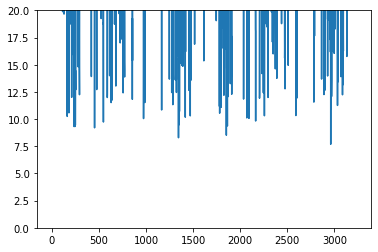

In [1085]:
plt.plot(vmax_data)
plt.ylim(0,20)

# Track Discretization

In [1086]:
from scipy.signal import find_peaks
#plt.plot(alts)
peaks = find_peaks(np.array(slopes),height=0.02,distance=100)[0]
troughs = find_peaks(-np.array(slopes)+max(slopes),height=0.02,distance=100)[0]
peaks2 = find_peaks(np.array(alts),height=10,distance=100)[0]
troughs2 = find_peaks(-np.array(alts)+max(alts),height=10,distance=100)[0]

In [1089]:
vmax = [p['vmax'] for p in points]
# convert vmax values to be based on x
max_dist = math.ceil(max(cum_dists))
vmax = np.zeros(max_dist)
print('hmm')
for i in range(max_dist):
    vmax[i] = data(i)[2]
print('hmm')
vmax_seps = find_peaks(-np.array(vmax)+max(vmax),height=20,distance=200)
heights = -vmax_seps[1]['peak_heights']+max(vmax)
cutoff = heights < 20

curveseps = vmax_seps[0]
curveseps = curveseps[cutoff]
brakeseps = np.array(curveseps)-100

print('hmm')

#plt.plot(cum_dists,vmax)


hmm
hmm
hmm


[40, 198, 315, 420, 557, 693, 821, 927, 1051, 1302, 1402, 1505, 1635, 1793, 1910, 2015, 2152, 2288, 2416, 2522, 2646, 2897, 2997, 3100, 84, 258, 437, 537, 722, 842, 1009, 1195, 1296, 1480, 1589, 1697, 1853, 2032, 2132, 2317, 2437, 2604, 2790, 2891, 3075, 3184, 49, 214, 317, 424, 617, 819, 991, 1109, 1238, 1403, 1546, 1651, 1813, 2019, 2212, 2414, 2586, 2704, 2833, 2955, 3063, 3165, 24, 180, 293, 412, 529, 652, 769, 900, 1026, 1186, 1299, 1486, 1619, 1775, 1888, 2007, 2124, 2247, 2364, 2495, 2621, 2739, 2894, 3081]


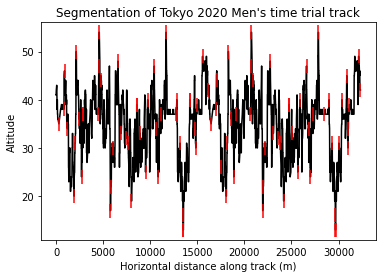

In [1090]:
seps = list(peaks)+list(troughs)+list(peaks2)+list(troughs2)
print(seps)
sep_x = [cum_dists[sep] for sep in seps]
#sep_x = np.append(sep_x,[curveseps, brakeseps])
sep_slope = [data(x)[0] for x in sep_x]
sep_alt = [data(x)[3] for x in sep_x]

#plt.scatter(curveseps,np.zeros(len(seps)))
#plt.scatter(brakeseps,np.zeros(len(seps)))
plt.plot([p['cumdist'] for p in points], [p['alt'] for p in points], color='black')
plt.scatter(sep_x, sep_alt,200, marker='|',color='red', zorder=3)
plt.xlabel('Horizontal distance along track (m)')
plt.ylabel('Altitude')
plt.title('Segmentation of Tokyo 2020 Men\'s time trial track')
plt.savefig('tokyo_seg.png', dpi=300)
plt.show()

94
31


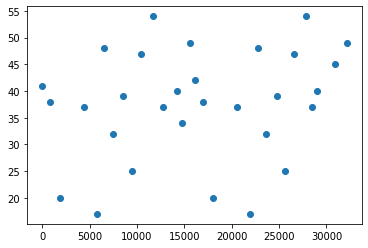

In [1091]:
segments = np.sort(np.append([0],sep_x))

segments = np.append(segments,np.inf)
print(len(segments))
new_segments = [0]
for i in range(1,len(segments)):
    if segments[i]>segments[i-1]+400:
        new_segments.append(segments[i])
segments = np.array(new_segments)

n_segments = len(segments)
print(n_segments)
plt.scatter(segments[:-1],[data(x)[3] for x in segments[:-1]])

In [1092]:
segments

array([    0.        ,   807.51652424,  1906.48862518,  4418.00264733,
        5773.99340958,  6569.77116643,  7425.01591362,  8576.2572231 ,
        9502.98284205, 10432.18443139, 11695.04479338, 12738.93068565,
       14189.04676512, 14796.16606829, 15551.65383524, 16125.54087145,
       16970.10790615, 18069.0800071 , 20580.59402924, 21936.58479149,
       22732.36254835, 23587.60729553, 24738.84860501, 25665.57422396,
       26594.7758133 , 27857.6361753 , 28439.60717509, 28984.32829907,
       30872.51603309, 32122.72055449,            inf])


# DIFF EQ

In [1093]:
time_levels = [180*60, 120*60, 60*60, 30*60, 15*60]
power_level_list = [[454.8557042607208,
  467.093193355624,
  488.10821632739726,
  509.3438468541454,
  510.226277074045],
 [349.50830893507407,
  362.34719049614966,
  385.16639086644005,
  410.0103761902225,
  418.10951600419065],
 [170.3028242330725,
  183.80879591969727,
  208.6292666666352,
  237.47579274370784,
  253.57999626856372]]
names = ['Filippo Ganna','Van Der Poel','Chloe Dygert']
ms = [82,75,67]

dedts = [-1/t for t in time_levels]
#P_to_t = {350: 17061, 400: 3800, 450: 712.8, 500: 288, 300: 86964}
# 1000: 2.78, 600:126
#keys_list = list(P_to_t.keys())
    
def dxdt(v, slope):
    return v * np.cos(slope)
def dvdt(a):
    return a
C_p = 320
def calc_dedt(p, alpha=1/(4*60*60)):
    if(p>C_p):
        return -1/P_to_t[p]
    else:
        return alpha * (C_p-p)/C_p

p_idx=3
def dedt_precalc(P):
    global p_idx
    #print(p_idx)
    time = np.zeros(P.shape)
    #print(P.shape)
    #print(power_level_list[p_idx])
    #print(dedts)
    #print(time)
    for i in range(len(time_levels)):
        #print(dedts[i])
        time += (P==power_level_list[p_idx][i]) * dedts[i]
    return time

v_seq = []
x_seq = []
vmax_seq = []
e_seq = []
dedt_seq = []

def step(x, v, e, seg_idx, next_seg, i, h, P, dedt_mat, verbose = False):
    global segments, x_max, base_power
    
    n = len(x)
    x[x>x_max]=x_max
    idx = np.floor(x/data_compr).astype(int)
    #slope = slope_data[idx]
    
    # get vmax and cap speed
    vmax = vmax_data[idx]
    vmax_seq.append(vmax[0])
    v = (v>vmax) * vmax + (v<=vmax) * v
    
    #update segment indices
    seg_idx += (x>=next_seg)
    cur_seg = segments[seg_idx]
    next_seg = segments[seg_idx+1]
    
    #calculate power
    base_power = 100 #TODO: REMOVE THIS LINE
    P_x = P[seg_idx,np.arange(0, n)] * (e>0) + base_power * (e<=0)

    hdg = hdg_data[idx]
    
    va = (v-wind_spd*np.cos(wind_hdg-hdg))
    
    a = (P_x/v - Cd*rho*A*(va**2)/2*np.sign(va) - m*fric_slope_data[idx])/m
    
    v = v + a * h
    v = v * (v>0) + 0.01 * (v<=0)
    v = (v>vmax) * vmax + (v<=vmax) * v
    x = x + dxdt(v, slope) * h
    e = e + dedt_mat[seg_idx,np.arange(0, n)] * h
    e = e * (e>0)
    
    if verbose:
        v_seq.append(v[0])
        x_seq.append(x[0])
        e_seq.append(e[0])
        dedt_seq.append(dedt_mat[seg_idx,np.arange(0, n)] * h)

#         x_sol[i,:] = x
#         v_sol[i,:] = v
#         e_sol[i,:] = e
    return x, v, e, seg_idx, next_seg

dedt_mat = 'hmmm'
def simulate(n, h, P, base_power = 200, verbose = False, sim_min=True, dedt_mat = None, splits=None):
    base_power = 150
    x_max = max(cum_dists)
    if p_idx==2: x_max/=2
    seg_idx = np.zeros(n).astype(int)
    next_seg = np.repeat(segments[1],n)
    x = np.zeros(n)
    #print(n)
    #print(len(x))
    v = np.zeros(n)+0.1
    e = np.zeros(n)+1
    if dedt_mat is None: dedt_mat = dedt_precalc(P)#np.zeros(P.shape)
#     for row in range(len(dedt_mat[:,0])):
#         for col in range(len(dedt_mat[0,:])):
#             dedt_mat[row,col] = calc_dedt(P[row,col])
    #print(dedt_mat.shape)
    
    #x_sol = np.zeros((iterations, n))
    #v_sol = np.zeros((iterations, n))
    #e_sol = np.zeros((iterations, n))
    i = 0
    #while(max(x)< x_max):
    k = 5
    thresh = k if n > k else 1
    if sim_min:
        while(np.sum(x>x_max)<thresh):
            x, v, e, seg_idx, next_seg = step(x, v, e, seg_idx, next_seg, i, h, P, dedt_mat, verbose)
            #if i%2000 == 0: print(max(x))
            i += 1
        return i * h#, x.argmin()
    elif splits is None:
        finish_times = np.zeros(n)
        while(np.sum(x<x_max)>0):
            x, v, e, seg_idx, next_seg = step(x, v, e, seg_idx, next_seg, i, h, P, dedt_mat, verbose)
            i += 1
            finish_times += (finish_times==0) * (x>=x_max) *i*h
        return finish_times
    elif splits is not None:
        split_times = np.zeros((len(splits),n))
        while(np.sum(x<x_max)>0):
            x, v, e, seg_idx, next_seg = step(x, v, e, seg_idx, next_seg, i, h, P, dedt_mat, verbose)
            i += 1
            for j in range(1,len(splits)):
                split_times[j,:] += (split_times[j,:]==0) * (x>=splits[j]) *(i*h)
        return split_times

# P=np.zeros((len(segments),10000))+400
# dedt_mat = np.zeros(P.shape)
# for row in range(len(dedt_mat[:,0])):
#     for col in range(len(dedt_mat[0,:])):
#         dedt_mat[row,col] = calc_dedt(P[row,col])
# simulate(100,h,P, verbose=True)
# plt.plot(v_seq)


# Tree Search

In [1094]:
#from pathos.multiprocessing import ProcessingPool as Pool
root = {'name': 'root', 'parent': None, 'power_seq' : []}
#dummy = {'name': 'root', 'parent': None, 'power_seq' : [300,330,350,360]}
def eval_node(node, n, h):
    global p_idx
    #print(p_idx)
    #print('evaluating node')
    P = np.zeros((n_segments, n))
    powers = node['power_seq']
    P[:len(powers),:] = np.repeat([powers],n,axis=0).T
    probs = 1/(np.array(power_level_list[p_idx])**3)
    probs = probs/sum(probs)
    P[len(powers):,:] = np.random.choice(power_level_list[p_idx],(n_segments-len(powers),n), p = probs)
    
    
    
    return simulate(n, h, P)
#eval_node(dummy, 1000, 0.5)
global n
n = 1000
h = 0.5

C_p = 286.898
alpha =  1/(2*60*60)
base_power = np.repeat(200,n)
#C_p = np.repeat(C_p,n)
node = root
x_max = max(cum_dists)
A=0.4
Cd = 0.6
rho = 1.29
m = 70
#mu = 0.00258
wind_spd = 7.5
wind_hdg = -math.pi/4

#todo: remove below
#wind_hdg = math.pi/2

In [1095]:
segments_tmp = segments
power_seqs = []
ps_examined = [0]
for p_idx in ps_examined:
    node = root
    if p_idx==2:
        n_segments=math.floor(n_segments/2)
        segments=np.append(segments[:n_segments],[np.inf])
        n_segments+=1
    m = ms[p_idx]
    for i in tqdm(range(n_segments)):
        #print('solving segment',i)
        vals = []

        children = []
#         for level in power_level_list[p_idx]:
#             children.append({'power_seq' : node['power_seq']+[level]})
    #     pool = Pool()
    #     vals = pool.map(eval_node, children, np.repeat(n,len(children)), np.repeat(h, len(children)))
        #print(vals)
        for level in power_level_list[p_idx]:
            #print('solving for power level',level)
            child = {'power_seq' : node['power_seq']+[level]}
            #p = mp.Process(target = eval_node, args = (child,n,h, ))
            #p.start()
            #p.join()
            #val, seq = q.get()
            val = eval_node(child, n, h)
            vals.append(val)
            children.append(child)
        node = children[np.argmin(vals)]
    power_seqs.append(node['power_seq'])
segments = segments_tmp
n_segments=len(segments)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:51<00:00,  3.59s/it]


# Analysis

In [1096]:
print(node['power_seq'])

[467.093193355624, 488.10821632739726, 488.10821632739726, 467.093193355624, 488.10821632739726, 467.093193355624, 488.10821632739726, 509.3438468541454, 488.10821632739726, 509.3438468541454, 509.3438468541454, 488.10821632739726, 488.10821632739726, 467.093193355624, 509.3438468541454, 467.093193355624, 488.10821632739726, 509.3438468541454, 467.093193355624, 509.3438468541454, 467.093193355624, 509.3438468541454, 467.093193355624, 509.3438468541454, 509.3438468541454, 509.3438468541454, 488.10821632739726, 509.3438468541454, 509.3438468541454, 454.8557042607208, 454.8557042607208]


In [1097]:
seq = node['power_seq']
print(min(vals))
P = np.repeat([seq],1, axis=0).T
h=0.05
print(simulate(1, h, P))

2667.5
2691.8


3032.5
hmm
hmm


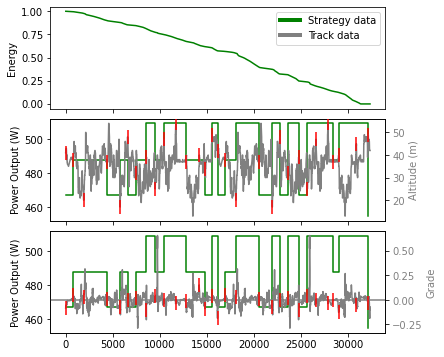

In [1098]:
# print(len(segments))
# print(len(power_seqs[0]))
postfix=""
#postfix = "-wind-opt"
colors = ['green','orange','blue']
seq = []
def plot_power(ax,color,label=False):
    ax.set_ylabel('Power Output (W)', color = 'black')
    #ax1.plot(x_seq,v_seq, color = 'red')
    ax.plot(np.repeat(segments[:-1],2)[1:],np.repeat(seq[:-1],2)[:-1], color = color) 
    ax.tick_params(axis ='y', labelcolor = 'black')
    print('hmm')
segments_tmp = segments

fig, axs = plt.subplots(3,figsize=(6,6),sharex='col',gridspec_kw={'hspace': 0.1, 'wspace': 0})
for p_idx, seq in enumerate(power_seqs):
    if p_idx==2:
        n_segments=math.floor(n_segments/2)
        segments=np.append(segments[:n_segments],[np.inf])
        n_segments+=1
    m = ms[p_idx]
    P = np.repeat([seq],1, axis=0).T
    #print(P)
    P.shape
    v_seq = []
    x_seq = []
    vmax_seq = []
    e_seq = []
    dedt_seq = []
    mu=0.00258
    wind_spd = 10
    wind_hdg = 0
    h = 0.5
    print(simulate(1, h, P, verbose=True))
#     print(len(x_seq) * h)
    #plt.plot(x_seq, e_seq)
    

    #energy
    ax1 = axs[0]
    #plot_power(ax1,color=colors[p_idx])
    #ax2 = ax1.twinx()
    ax1.set_ylabel('Energy') 
    ax1.plot(x_seq, e_seq, color = colors[p_idx])
    #plt.ylim(0,1)
    ax1.tick_params(axis ='y', labelcolor = 'black')
    #plt.scatter(segments[:-1],[data(seg)[3] for seg in segments[:-1]], 200, marker='|',color='red', zorder=3)
    
    ax1 = axs[1]
    plot_power(ax1,color=colors[p_idx])
    ax1 = axs[2]
    plot_power(ax1,color=colors[p_idx])
#     ax1 = axs[3]
#     plot_power(ax1,color=colors[p_idx])
    #altitude
segments = segments_tmp
n_segments=len(segments)
    
ax1 = axs[1]
ax2 = ax1.twinx()
ax2.set_ylabel('Altitude (m)', color = 'grey') 
ax2.plot(cum_dists, alts, color = 'grey') 
ax2.tick_params(axis ='y', labelcolor = 'grey')
plt.scatter(segments[:-1],[data(seg)[3] for seg in segments[:-1]], 200, marker='|',color='red', zorder=3)

#grade
ax1 = axs[2]
ax2 = ax1.twinx() 
ax2.set_ylabel('Grade', color = 'grey') 
ax2.plot(cum_dists, slopes, color = 'grey') 
ax2.tick_params(axis ='y', labelcolor = 'grey')
plt.axhline(0, color='grey')
plt.scatter(segments[:-1],[data(seg)[0] for seg in segments[:-1]], 200, marker='|',color='red', zorder=3)

#wind
# ax1 = axs[3]
# ax2 = ax1.twinx() 
# ax2.set_ylabel('Headwind (m/s)', color = 'grey') 
# ax2.plot(cum_dists, np.cos(np.array(dirs)-wind_hdg)*wind_spd, color = 'grey') 
# ax2.tick_params(axis ='y', labelcolor = 'grey')
# plt.axhline(0, color='grey')
# ax1.set_xlabel('Horizontal distance along track (m)') 
    #plt.scatter(segments[:-1],np.cos(np.array([data(seg)[4] for seg in segments[:-1]])-wind_hdg)*wind_spd, 200, marker='|',color='red', zorder=3)
    
    #velocity
#     ax1 = axs[4]
#     plot_power(ax1)
#     ax2 = ax1.twinx() 
#     ax2.set_ylabel('Velocity (m/s)', color = 'black') 
#     ax2.plot(x_seq, v_seq, color='grey')
#     #ax2.plot([p['cumdist'] for p in points], [p['vmax'] for p in points], color = 'black') 
#     ax2.tick_params(axis ='y', labelcolor = 'black')
#     #plt.axhline(0, color='grey')
#     #plt.ylim(0,40)
#     if p_idx==2: plt.xlim(0,x_max/2)
#     ax1.set_xlabel('Horizontal distance along track (m)') 
#     #plt.title('Optimal strategy for '+names[p_idx]+" at Athens 1896")



from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='green', lw=4),
                #Line2D([0], [0], color='orange', lw=4),
                #Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='grey', lw=4)]

axs[0].legend(custom_lines, ['Strategy data']+['Track data'])


plt.savefig('results/'+city+postfix+'.png',dpi=300,bbox_inches='tight')
plt.show()


In [588]:
n=10000
p_idx=0
wind_hdg = np.random.rand(n)*2*math.pi
wind_spd = np.random.rand(n)*15
P = np.repeat([seq],n, axis=0).T
wind_results = simulate(n, h, P, sim_min=False)

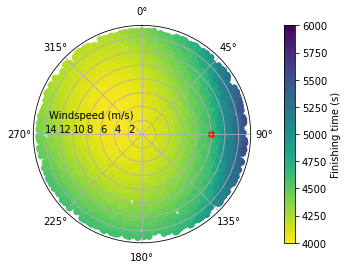

In [600]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
wind_results[200] = 4000
wind_results[201] = 6000
sc = ax.scatter(wind_hdg, wind_spd, c=wind_results, cmap=cm.viridis_r)
good = wind_results<4140.5
import matplotlib.colors as colors
ax.scatter(math.pi/2,10,color='red')

# import scipy
# hull = scipy.spatial.ConvexHull(np.array(list(zip(wind_hdg[good],wind_spd[good]))), incremental=False, qhull_options=None)
#scipy.spatial.convex_hull_plot_2d(hull)
#plt.ylim(min(wind_results),max(wind_results))
cbar = plt.colorbar(sc,orientation="vertical", pad=0.1,label="Finishing time (s)")
#cbar.set_clim(4000,6000)
ax.set_rlabel_position(-90)
#ax.scatter(wind_hdg[good], wind_spd[good], color='white',alpha=1)
label_position=ax.get_rlabel_position()
#plt.xlim(0,2*math.pi)
#plt.ylim(0,15)
ax.text(np.radians(label_position+20),ax.get_rmax()/2.,'Windspeed (m/s)',
        rotation=0,ha='center',va='center')

ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
#ax.legend(*sc.legend_elements(),
#                    loc="lower right", title="Price")
plt.savefig('wind-finish2.png',dpi=300,bbox_inches='tight')

array([[ 5.41573709, 13.42487226],
       [ 5.86527833,  5.65836646],
       [ 5.22158662,  9.0041834 ],
       ...,
       [ 4.17878325,  6.45268966],
       [ 4.26313171,  0.03629725],
       [ 6.12003955,  7.50775921]])

(array([5491., 1675.,  763.,  607.,  594.,  399.,  152.,  154.,  105.,
          60.]),
 array([3968.5, 4079.1, 4189.7, 4300.3, 4410.9, 4521.5, 4632.1, 4742.7,
        4853.3, 4963.9, 5074.5]),
 <BarContainer object of 10 artists>)

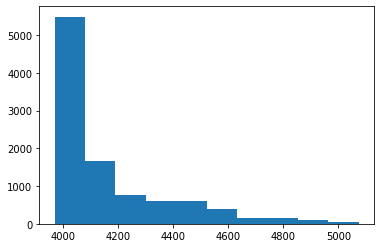

In [315]:
np.mean(wind_results)
plt.hist(wind_results)

In [296]:
wind_hdg = wind_hdg[np.argmax(wind_results)]
wind_spd = wind_spd[np.argmax(wind_results)]
print(wind_hdg,wind_spd)

1.559196574255781 9.92868472585425


31


/tmp/ipykernel_265458/358436653.py:8: RuntimeWarning: overflow encountered in exp
  y = (W1/x*(1-np.exp(-x/(W1/(Pmax-CP)))) + CP - A*(np.log(x/cpmax))*(x>cpmax))


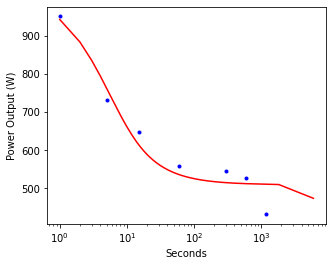

In [390]:
# getting Filippo Ganna's power curve
names = ['Filippo Ganna','Van Der Poel','Chloe Dygert']

x = [1,5,15,60, 60*5, 60*10, 60*20]
powers = [951, 732, 646,558, 544, 526, 431]

def func(x,W1,Pmax, CP, A, cpmax):
    y = (W1/x*(1-np.exp(-x/(W1/(Pmax-CP)))) + CP - A*(np.log(x/cpmax))*(x>cpmax))
    return y
startPmax = 1000
startW = 10000
startCP =200
startA =30
startCPmax=1800

MaxTime = 7200

plt.figure(figsize = (5,4))
#time_levels = [180*60, 120*60, 60*60, 30*60, 15*60]
time_levels = [180*60, 150*60, 120*60, 90*60, 60*60, 45*60, 30*60, 15*60, 10*60]
power_levels = []

#for i in range(len(names)):
print(i)
w1, pmax, cp, a, cpmax = scipy.optimize.curve_fit(func, xdata = x, ydata=powers, p0 = [startW,startPmax,startCP,startA,startCPmax], bounds = ([0,0,0,0,0],[np.inf,np.inf,np.inf,np.inf,np.inf]),maxfev=50000)[0]
#func(100,w1,pmax,cp,a,cpmax)
pred1 = []
pred2 = []
totl = []
for j in range(1,6000):
    pred1.append(func(j,w1, pmax, cp, a, cpmax))
    totl.append(j)

power_levels.append([func(time_levels[k],w1,pmax, cp, a, cpmax) for k in range(len(time_levels))])
plt.plot(x, powers, 'b.')
#plt.plot(x2, p2, 'b.')
plt.plot(totl, pred1, 'r', label = "Puncheur")
#plt.plot(totl, pred2, 'b', label = "Time-Trialist")
plt.xlabel('Seconds')
plt.ylabel('Power Output (W)')
#plt.legend()
plt.xscale('log')
#plt.savefig('Power_comparison', dpi=300, bbox_inches='tight')
plt.show()

In [982]:
n=1
def diff(time,power):
    yt = func(time,w1,pmax,cp,a,cpmax)
    return (yt - power )**2

def get_time(p):
    return scipy.optimize.minimize(diff, 1, args=(p), method='Nelder-Mead', tol=1e-6).x[0]
# power = 500 ## Put the power you want the time of here
# res = (scipy.optimize.minimize(diff, 1, args=(power), method='Nelder-Mead', tol=1e-6))

P = np.repeat([seq],n, axis=0).T
# P += np.random.normal(loc=0, scale=0.02,size=P.shape)*P
dedt_mat = np.zeros(P.shape)
for row in tqdm(range(len(dedt_mat[:,0]))):
    for col in range(len(dedt_mat[0,:])):
        dedt_mat[row,col] = -1/get_time(P[row,col])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 201.38it/s]


In [983]:
results = simulate(n, h, P, sim_min=False, dedt_mat = dedt_mat, splits=splits)

In [985]:
print(results.T)

[[   0.    60.5   98.5  200.5  313.   464.   585.5  770.   818.5 1052.
  1318.5 1370.5 1421.  1528.5 1557.5 1689.5 1744.  1897.5 2018.5 2201.
  2249.  2612.5 2848.  3077.5]]


In [978]:
split_times = np.zeros(results.shape)
for i in range(1,len(results)):
    split_times[i,:] = results[i,:]-results[i-1,:]
print(len(split_times))

24


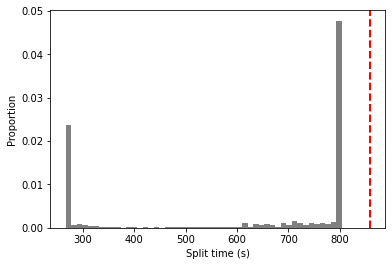

In [980]:
fig, ax = plt.subplots(1, 1)
ax.hist(split_times[10],bins=50,density=True,color='grey')
plt.xlabel('Split time (s)')
plt.ylabel('Proportion')
ax.axvline(x=858.5, color='r', linestyle='dashed', linewidth=2)
plt.savefig('split11.png',dpi=300,bbox_inches='tight')

In [ ]:
split_times[11]

In [538]:
splits[10]

25753.535234138413

In [580]:
np.var(P[:,np.argmax(split_times[11])]-np.array(seq))

125.3682971640151

In [971]:
splits = find_peaks(np.array(alts),height=10,distance=100)[0]
splits2 = find_peaks(-np.array(alts)+max(alts),height=10,distance=100)[0]
splits = list(splits)+list(splits2)
splits_x = [cum_dists[sep] for sep in splits] + [x_max/2]+[x_max]
splits = np.sort(np.append([0],splits_x))

In [986]:
np.round(splits)

array([    0.,  1006.,  1516.,  2836.,  4439.,  6898.,  7891., 10956.,
       11689., 14557., 16824., 17424., 17924., 19438., 19827., 21594.,
       22362., 24820., 25813., 28878., 29611., 33627., 34747., 35847.])

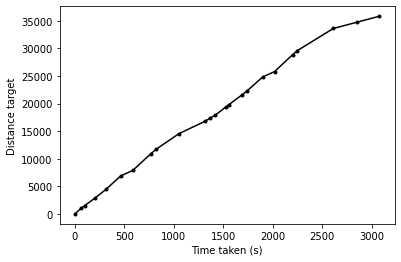

In [999]:
plt.plot(results.T[0], splits,marker='.',color='black')
plt.xlabel('Time taken (s)')
plt.ylabel('Distance target')
plt.savefig('split-targets.png',dpi=300,bbox_inches='tight')
plt.show()

In [973]:
v_seq = []
x_seq = []
vmax_seq = []
e_seq = []
dedt_seq = []
mu=0.002
wind_spd = 10
wind_hdg = 0
h = 0.5
print(simulate(1, h, P, verbose=True))

3077.5


In [974]:
power_seqs_tokyo = power_seqs

In [975]:
splits

array([    0.        ,  1005.95494901,  1515.53529185,  2836.45586759,
        4439.43150895,  6897.71299898,  7890.51913725, 10955.56430196,
       11688.7273456 , 14557.05051982, 16824.1020068 , 17424.13030012,
       17923.52815938, 19437.95995794, 19826.89713639, 21594.06984502,
       22361.89767981, 24820.17905763, 25812.99195687, 28878.12397253,
       29611.28774394, 33626.70096165, 34746.66884869, 35847.05631875])